<div align="center">
  <h1>Finding Optimal KNN Parameters for MNIST</h1>
  <p style="font-size: 14px;">28.10.2024</p>
</div>

---

# Problem 1: Finding the Optimal *k* and Bootstrap Iterations

#### **Introduction**

In this problem, we apply the classical **K-Nearest Neighbors** (KNN) classifier to the task of classifying handwritten digits from the **MNIST** dataset. The primary objective is to determine the **optimal number of neighbors k** for the KNN algorithm, as well as the **optimal number of bootstrap iterations** required to accurately estimate the model's performance.

#### **Tools and Libraries**

We will use the **KNeighborsClassifier** from the *sklearn.neighbors* library for implementing the KNN algorithm. The data we use is from **MNIST** dataset, which contains images of handwritten digits. Firstly, let's import the necessary libraries and load the data into our code.

###### Make sure you have latest pip version and pandas/scikit-learn packages 

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
from tqdm import tqdm

#### **Data Analysis**

Now let's **fetch** the data from the **scikit-learn** dataset and play around a little bit.

In [2]:
dataset = fetch_openml('mnist_784')
dataset.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Variable "dataset" is of [Bunch](https://scikit-learn.org/1.5/modules/generated/sklearn.utils.Bunch.html#sklearn.utils.Bunch) type. Now we retrieve the actual data that interests us:

In [3]:
data: pd.DataFrame = dataset['data']
labels: pd.Series = dataset['target']

labels.astype(int)

data = data / 255.0

print("Data shape: ", data.shape, '\n')
print(labels.head())
print("Labels shape: ", labels.shape)

Data shape:  (70000, 784) 

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']
Labels shape:  (70000,)


As we can see, we have **70000** images, all of shape: **28x28** pixels. Thus we can say that every image lies somewhere in the $\mathbb{R}^{784}$ **space grid**. This is the key observation that we will use later on when working with **KNN algorithm**.  

Another key observation is that our labels consist of 10 categories: **numbers 0-9**
and it's shape is **70000x1**. 

More about pandas DataFrame [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

#### **Data Preprocessing**

1. The value of each pixel varies from **0 to 255**, so firstly we can scale every    pixel to be between **0 and 1** using pandas *in-place element-wise* operation.  
   
2. For faster experimentation let's limit ourselves to random 10% of the dataset.

In [4]:
# We then merge the labels with the corresponding images.
# Thus keeping track of the correct image labeling in our 10% sample
data['label'] = labels

data = data.sample(frac=0.1)

labels = data['label'].to_numpy()
data = data.drop('label', axis=1).values

data = np.ascontiguousarray(data)
labels = np.ascontiguousarray(labels)

print(data.flags['C_CONTIGUOUS'])

True


#### **KNN Classifier**

Firstly, we need to **fit** our classifier to the data we sampled. This **training data** is stored and later used to **classify** arbitrary input we give it. Note that the name *training data* is a bit misleading, because there is no training process! 

The KNN algorithm works as follows (for some out-of-bag data):
- Calculate distances to all the previously fitted data using [Euclidian](https://en.wikipedia.org/wiki/Euclidean_distance)/[Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry)/[Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance)/... method.
- Choose **top k** closest entries to our input
- **Vote** for the class of our input data (as the *majority*)

#### **Determining Optimal k and Bootstrap Iterations**

Each **Bootstrap Iteration** consists of these steps:
- **Resample** dataset with replacement (it's like sampling from population)
- Fit sample to the KNN model
- Validate the model on **OOB** data
- Store the **accuracy** for each iteration

Now for each k:
1. Iterate through number *iters* of Bootstrap iterations
2. For each number *iter* do *iter* times Bootstrap sampling
3. Calculate the mean of accuracies over the iterations
4. Store it for each *iters*
5. Store this data for each *k*

###### Note: Code below will take approximately 8.5 minutes to run...

In [13]:
k_range = range(1, 11)
iter_range = [1, 2, 11, 22, 44, 88, 172, 344]
result = {}
np.random.seed(42)

for k in k_range:
  k_accuracy = []

  for iters in tqdm(iter_range):
    iter_accuracy = []
    
    for iter in range(iters):
      indecies = np.random.choice(len(data), size=int(len(data)), replace=True)
      y_train = labels[indecies]
      x_train = data[indecies]

      knn = KNeighborsClassifier(n_neighbors=k)

      knn.fit(x_train, y_train)

      x_valid = np.delete(data, indecies, axis=0)
      y_valid = np.delete(labels, indecies, axis=0)

      accuracy = knn.score(x_valid, y_valid)

      iter_accuracy.append(accuracy)
    
    k_accuracy.append(np.mean(iter_accuracy))

  result[k] = k_accuracy

print(result)

100%|██████████| 8/8 [01:58<00:00, 14.76s/it]

{1: [np.float64(0.928812289246909), np.float64(0.9348700540368156), np.float64(0.930521497330496), np.float64(0.9316460502823087), np.float64(0.9324408507986379), np.float64(0.9324405806785894), np.float64(0.9319381424251504), np.float64(0.9315382527302911)], 2: [np.float64(0.9186676994577847), np.float64(0.9262879160127315), np.float64(0.9234222467238218), np.float64(0.9219481999380622), np.float64(0.924377809718412), np.float64(0.9236396422739105), np.float64(0.9233389700359269), np.float64(0.922985277729486)], 3: [np.float64(0.9232866043613707), np.float64(0.925448423783299), np.float64(0.9262178203954942), np.float64(0.9251298337083363), np.float64(0.9247679941377857), np.float64(0.924829137045636), np.float64(0.9249267085777823), np.float64(0.9246435064105375)], 4: [np.float64(0.9159274971075974), np.float64(0.9236924277907885), np.float64(0.9230259485903765), np.float64(0.9217300372681275), np.float64(0.9214627168169831), np.float64(0.9209482179548479), np.float64(0.9209141511932

##### Finding optimal value for k

As we see each value of k has some **mean accuracy for each number of Bootstrap iterations**. Now to determine which value for k is **optimal**, we can **compute means** of those accuracies and take **maximum**.

In [14]:
optimal_k = -1
optimal_mean = 0

# Save for later
mean_for_k = []

for k, mean_accuracies in result.items():
  mean = np.mean(mean_accuracies)
  mean_for_k.append(mean)

  if (mean > optimal_mean):
    optimal_k = k
    optimal_mean = mean

print(optimal_k)

1


As we see the optimal k value is **1** (as of the result I got while writing this paragraph).

#### Finding optimal number of Bootstrap iterations

Now for the **optimal k**, we deduce the best **number of iterations** by simply taking the **minimum** value for which the result seems to **stabilize**...

In [15]:
optimal_iterations = result[optimal_k]

for i in range(len(optimal_iterations) - 1):
  print(abs(optimal_iterations[i] - optimal_iterations[i + 1]))


0.006057764789906606
0.004348556706319506
0.0011245529518126851
0.000794800516329186
2.701200485510924e-07
0.000502438253438986
0.00039988969485926784


As we see the optimal number of iterations is between **11-88**, and we can deduce that the results stabilize around **44**.




## **Plot the result data**

Now for each value of k we can **plot** its mean accuracy across different number of Bootstrap iterations.

(0.9, 0.98)

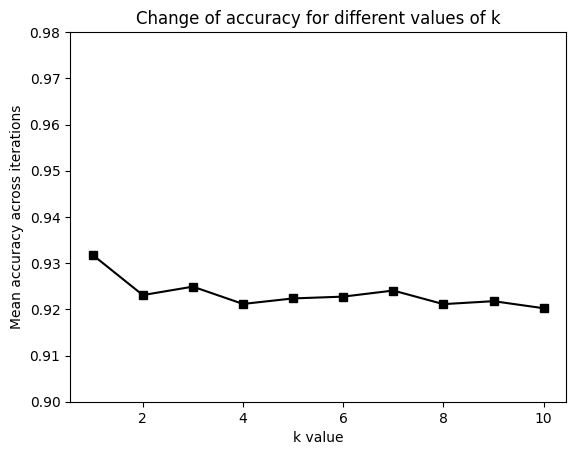

In [16]:
import matplotlib.pyplot as plt

plt.plot(k_range, mean_for_k, marker='s', color='black')
plt.xlabel('k value')
plt.ylabel('Mean accuracy across iterations')
plt.title('Change of accuracy for different values of k')
plt.ylim(0.9, 0.98)

As we see, for our problem as the **k increases** the **mean accuracy tends to decrease**, so our best option for k value is indeed **1**.  

Let's also **visualize** how (for the best k) the change of number of iterations **impacts** model's calculated mean accuracy.

(0.92, 0.96)

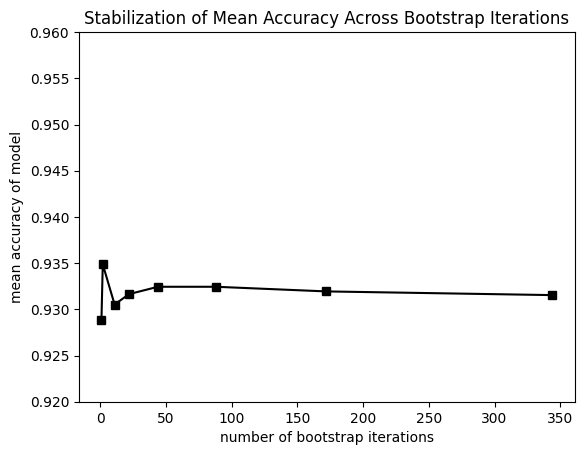

In [17]:
plt.plot(iter_range, optimal_iterations, marker='s', color='black')
plt.xlabel('number of bootstrap iterations')
plt.ylabel('mean accuracy of model')
plt.title('Stabilization of Mean Accuracy Across Bootstrap Iterations')
plt.ylim(0.92, 0.96)

As we see, our plot **stabilizes** around 44 mark, so the best option for number of iterations is indeed **44**.

## **Final thoughts**

We have explored and played around with different parameters for our KNN classifier and came to the conclusion that the best value for parameter k is 1, as the higher values tend to decrease the mean accuracy of the model. And the best value for number of Bootstrap Iterations is 44, cause from this point on, the calculated mean accuracy of the model seems to stabilize.

---
<div style="text-align: right;">
Piotr Stachowicz  
 
337942
</div>